# PCA 範例
* 以 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化

In [12]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [13]:
# 載入手寫數字辨識集
digits = datasets.load_digits()
X = digits.data
y = digits.target

print(X.shape, y.shape)
print(np.unique(y))
print(np.bincount(y))

(1797, 64) (1797,)
[0 1 2 3 4 5 6 7 8 9]
[178 182 177 183 181 182 181 179 174 180]


# 作業
* 將參數 penalty 改為 L1, max_iter 改為 100, 觀察 PCA 與羅吉斯迴歸做手寫辨識的效果

In [14]:
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model, params, error_score=0, cv=5, n_jobs=-1)
    grid.fit(X, y)
    print(f"Best accuracy: {grid.best_score_:.3f}")
    print(f"Best parameters: {grid.best_params_}")
    print(f"Avg. time to fit: {grid.cv_results_['mean_fit_time'].mean():.3f}")
    print(f"Avg. time to predict: {grid.cv_results_['mean_score_time'].mean():.3f}")

In [15]:
# 執行 GridSearchCV 跑出最佳參數
# 定義 PCA 與隨後的羅吉斯迴歸函數
# penalty 改為 L1, max_iter 改為 100
model = Pipeline(steps=[
    ('pca', PCA()),
    ('logistic', SGDClassifier(loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0))
])

params = {
    'pca__n_components': [1, 2, 4, 8, 16, 32, 64],
    'logistic__alpha': [1e-3, 1e-2, 1e-1, 1],
}

get_best_model_and_accuracy(model, params, X, y)

Best accuracy: 0.913
Best parameters: {'logistic__alpha': 0.01, 'pca__n_components': 32}
Avg. time to fit: 0.474
Avg. time to predict: 0.003


Text(0, 0.5, 'explained_variance_ratio')

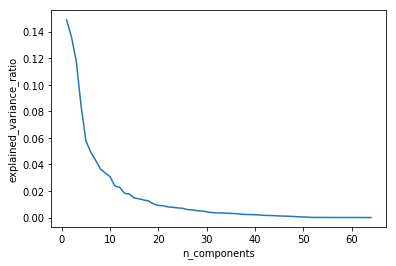

In [16]:
# 繪製不同 components 的 PCA explained variance ratio
pca = PCA(n_components=64)
pca.fit(X)
plt.plot(np.arange(64)+1, pca.explained_variance_ratio_)
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')

In [17]:
# 繪製不同採樣點的 accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)

df = pd.DataFrame({}, columns=['n_components', 'accuracy', 'precision', 'recall', 'f1'])
df['n_components'] = [1, 2, 4, 8, 16, 32, 64]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for n_components in [1, 2, 4, 8, 16, 32, 64]:
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    clf = SGDClassifier(alpha=0.01, loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='macro'))
    recall_scores.append(recall_score(y_test, y_pred, average='macro'))
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    
df['accuracy'] = accuracy_scores
df['precision'] = precision_scores
df['recall'] = recall_scores
df['f1'] = f1_scores
df

,n_components,accuracy,precision,recall,f1
0,1,0.302222,0.222463,0.298696,0.245570
1,2,0.464444,0.636582,0.462138,0.492984
2,4,0.784444,0.797663,0.784669,0.786346
3,8,0.873333,0.871146,0.873050,0.871474
4,16,0.944444,0.945078,0.944154,0.944316
5,32,0.944444,0.945113,0.943657,0.943700
6,64,0.937778,0.938154,0.937291,0.937226


Text(0, 0.5, 'accuracy score')

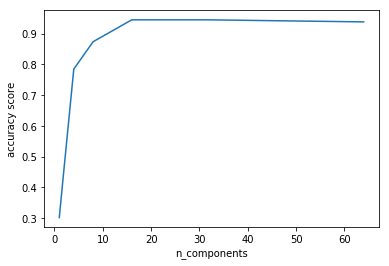

In [18]:
plt.plot(df['n_components'], df['accuracy'])
plt.xlabel('n_components')
plt.ylabel('accuracy score')